<a href="https://colab.research.google.com/github/ryujimorita/dev_connector/blob/master/pawpularity_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up RAPIDS

In [1]:
!curl ipinfo.io

{
  "ip": "34.82.43.82",
  "hostname": "82.43.82.34.bc.googleusercontent.com",
  "city": "The Dalles",
  "region": "Oregon",
  "country": "US",
  "loc": "45.5946,-121.1787",
  "org": "AS396982 Google LLC",
  "postal": "97058",
  "timezone": "America/Los_Angeles",
  "readme": "https://ipinfo.io/missingauth"
}

In [2]:
# Check Python version
!python --version
print('*'*79)
# Check Ubuntu Version
!lsb_release -a
print('*'*79)
# Check CUDA/cuDNN Version
!nvcc -V && which nvcc
print('*'*79)
# check GPU type (cuml works with certain kind of GPU)
!nvidia-smi

Python 3.7.12
*******************************************************************************
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic
*******************************************************************************
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
/usr/local/cuda/bin/nvcc
*******************************************************************************
Fri Dec 31 09:34:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-

In [3]:
# check if the runtime is compatible with RAPIDS
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
  raise Exception("""
    Unfortunately this instance does not have a T4, P4 or P100 GPU.
    
    Please make sure you've configured Colab to request a GPU instance type.
    
    Sometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100. Resetting the instance.
If you get a K80 GPU, try Runtime -> Reset all runtimes...
  """)
else:
  print('Woo! You got the right kind of GPU!')

Woo! You got the right kind of GPU!


In [4]:
# # Fetch the Rapids Colab installation files
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/env-check.py

In [5]:
# # This will update the Colab environment and restart the kernel.  
# # Don't run the next cell until you see the session crash.
# !bash rapidsai-csp-utils/colab/update_gcc.sh
# import os
# os._exit(00)

In [6]:
# # Install CondaColab.  This will restart your kernel one last time.  
# # Run this cell by itself and only run the next cell once you see the session crash.
# import condacolab
# condacolab.install()

In [7]:
# # This is the last time that the session will crash and the kernel restarts. 
# # After restart, you can check if the installation was successful by running this command
# import condacolab
# condacolab.check()

In [8]:
# # The last setup command and the most time taking (around 15 minutes) is for 
# # installing the Rapids on the colab instance and copying the files into the current working directory.

# !python rapidsai-csp-utils/colab/install_rapids.py stable
# import os
# os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
# os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
# os.environ['CONDA_PREFIX'] = '/usr/local'

In [9]:
# Execute this cell in google colab
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [10]:
# Execute this cell in google colab

# install libraries 
!pip install timm
!pip install fastai --upgrade

# Import Libraries

In [11]:
import math
import gc
import sys
# In kaggle notebook, internet needs to be disconnected. Add this timm path to import the module.
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

from IPython.display import display
from PIL import Image
from tqdm import tqdm

# data manipulation & visualization
import numpy as np
import pandas as pd

# make display size bigger for pandas
d = {'display.max_rows': 50,
     'display.max_columns': 50}
[pd.set_option(k, v) for k, v in d.items()]

import matplotlib.pyplot as plt
import seaborn as sns
# Change fig style
sns.set()

# sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from timm import create_model
import timm
import fastai
from fastai.vision.all import *
from fastai.tabular.all import *

# Data Preprocessing

## Define Constraints

In [12]:
# to include meta data, set USE_META to True. Set this to False when using features extracted from images
USE_META = True

# in google colab, set USE_COLAB to True. In Kaggle notebook, set this to False
if 'google.colab' in str(get_ipython()):
    USE_COLAB = True
else:
    USE_COLAB = False

In [13]:
# Constraints for the model
SEED = 48
BATCH_SIZE = 8
IMAGE_SIZE = 224
EPOCH = 5
MODEL_NAME = "swin_large_patch4_window7_224"

# set path for data and number of workers accordingly
if USE_COLAB:
    # colab's dataset path (google drive)
    dataset_path = Path('/content/drive/MyDrive/kaggle/pawpularity/')
    NUM_WORKERS = 2
else:
    # kaggle notebook's dataset path
    dataset_path = Path('../input/petfinder-pawpularity-score/')
    NUM_WORKERS = 4

In [14]:
# define path to train and test data
train_df = pd.read_csv(dataset_path/'train.csv')
test_df = pd.read_csv(dataset_path/'test.csv')

In [15]:
# create image path for each row for both train and test data
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')

# drop id column for train
train_df = train_df.drop(columns=['Id'])
#shuffle the train dataframe completely
train_df = train_df.sample(frac=1).reset_index(drop=True) 

In [16]:
# check train_df data size
len_df = len(train_df)
print(f"There are {len_df} images")

There are 9912 images


In [17]:
# create test df pawpularity column with 1 to store predicted Pawpularity score
test_df['Pawpularity'] = [1]*len(test_df)
# drop id for test data
test_df = test_df.drop(columns=['Id'])

# EDA

The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.591990105774542


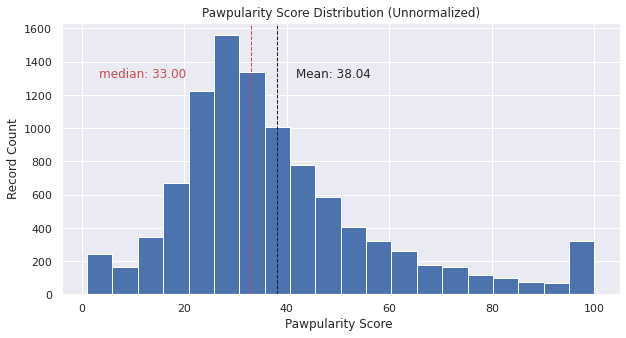

In [18]:
# plot pawpularity score distribution
x = train_df['Pawpularity']
plt.figure(figsize=(10, 5))
plt.hist(x, bins=20)
plt.xlabel('Pawpularity Score ')
plt.ylabel('Record Count')
plt.title('Pawpularity Score Distribution (Unnormalized)')

# add mean and median to the histogram
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(x.median(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.8, 'Mean: {:.2f}'.format(x.mean()))
plt.text(x.median()*0.1, max_ylim*0.8, 'median: {:.2f}'.format(x.median()), c='r')

# print mean, median, and standard deviation of pawpularity score
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

In [19]:
# count unique value of pawpularity score
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

There are 100 unique values of Pawpularity score


In [20]:
len_df = len(train_df)
print(f"There are {len_df} images")

There are 9912 images


# Feature Engineering

## Image ratio feature

In [21]:
if USE_COLAB:
  # in colab, it takes more time to get height & width for all the images from google drive. 
  # Use the precalculated df(pickle) instead to save time.
  train_df = pd.read_pickle(dataset_path/'train_img_ratio.pkl')
  counter_df = pd.read_pickle(dataset_path/'counter.pkl')
  display(counter_df.head())
else:
  # create an empty dictionary for size count
  counter = {}

  # create empty columns to store values in the next iteration
  train_df['img_width']= 0
  train_df['img_height'] = 0
  train_df['img_size'] = ''
      
  # count each image size
  for i in tqdm(range(len(train_df))):
    # open method used to open different extension image file
    im = Image.open(train_df["path"][i]) 
    width, height = im.size
    width_height_str = str(width) + '_' + str(height)
    
    # add each image's width, height and image size columns to train_df
    train_df.loc[i, 'img_width'] = width
    train_df.loc[i, 'img_height'] = height
    train_df.loc[i, 'img_size'] = width_height_str
    
    # update the counter dict
    if width_height_str not in (counter):
        counter[width_height_str] = 1
    else:
        counter[width_height_str] += 1

  # convert the dict to df
  counter_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
  counter_df = counter_df.rename(columns={0: 'count_num', 'index': 'img_size'})\
                        .sort_values(by=['count_num'], ascending=False)
  display(counter_df.head())

,img_size,count_num
2,720_960,3527
3,1280_960,802
0,540_960,619
29,1280_1280,302
1,960_960,272


In [22]:
# write train_df image size as pickle since getting height and width info for all images from google drive takes time
# train_df.to_pickle(dataset_path/'train_img_ratio.pkl')
# counter_df.to_pickle(dataset_path/'counter.pkl')

Text(0.5, 1.0, 'Image Size : Record Count')

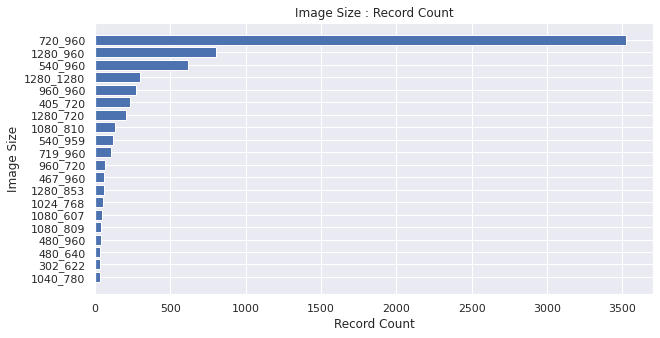

In [23]:
# plot img_size
x = counter_df['count_num'].head(20)
y = counter_df['img_size'].head(20)

plt.figure(figsize=(10, 5))
plt.barh(y, x)
plt.gca().invert_yaxis()
plt.xlabel('Record Count')
plt.ylabel('Image Size')
plt.title('Image Size : Record Count')

In [24]:
# create image's size ratio
def find_image_ratio(row) -> str:
    """
    compare image's width and height to label image size ratio
    """
    if row['img_width'] > row['img_height']:
        return 'horizontal'
    elif row['img_width'] < row['img_height']:
        return 'vertical'
    else:
        return 'square'
    
train_df['image_ratio'] = train_df.apply(find_image_ratio, axis=1)
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,img_width,img_height,img_size,image_ratio
0,0,0,1,1,0,0,0,0,0,0,0,1,50,/content/drive/MyDrive/kaggle/pawpularity/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg,540,960,540_960,vertical
1,0,1,1,1,0,1,0,1,0,0,1,0,25,/content/drive/MyDrive/kaggle/pawpularity/train/25e3bf4267c2dc3f579b779418221bb7.jpg,960,960,960_960,square
2,0,0,1,1,0,1,0,0,0,0,0,0,27,/content/drive/MyDrive/kaggle/pawpularity/train/6548166fb3fda22b67881176397f0223.jpg,720,960,720_960,vertical
3,0,1,1,1,0,0,0,0,1,1,0,0,19,/content/drive/MyDrive/kaggle/pawpularity/train/472c40116e1833555715e4774445ae5b.jpg,720,960,720_960,vertical
4,0,1,1,1,0,0,0,1,0,0,0,0,27,/content/drive/MyDrive/kaggle/pawpularity/train/7b77e1a6d93667b575d57db83facd860.jpg,1280,960,1280_960,horizontal


In [25]:
# check mean pawpularity for each image size ratio
train_df.groupby(by=['image_ratio'])['Pawpularity'].describe()

,count,mean,std,min,25%,50%,75%,max
image_ratio,,,,,,,,
horizontal,2568.0,37.690421,20.425708,1.0,25.00,33.0,46.0,100.0
square,678.0,38.094395,20.963496,1.0,24.25,34.0,48.0,100.0
vertical,6666.0,38.167717,20.619223,1.0,25.00,33.0,46.0,100.0


In [26]:
# one hot encoding for the image size ratio label
dummy_df = pd.get_dummies(train_df['image_ratio'])

dummy_columns = ['horizontal', 'vertical', 'square']
# if there is no horizontal or vertical in test_df columns, add the column with value 0
for i in dummy_columns:
  if i not in dummy_df.columns:
    train_df[i] = 0

train_df = train_df.merge(dummy_df, left_index=True, right_index=True)

# drop unnecessary image related columns 
train_df = train_df.drop(columns=['img_size', 'img_width', 'img_height', 'image_ratio'])
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,horizontal,square,vertical
0,0,0,1,1,0,0,0,0,0,0,0,1,50,/content/drive/MyDrive/kaggle/pawpularity/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg,0,0,1
1,0,1,1,1,0,1,0,1,0,0,1,0,25,/content/drive/MyDrive/kaggle/pawpularity/train/25e3bf4267c2dc3f579b779418221bb7.jpg,0,1,0
2,0,0,1,1,0,1,0,0,0,0,0,0,27,/content/drive/MyDrive/kaggle/pawpularity/train/6548166fb3fda22b67881176397f0223.jpg,0,0,1
3,0,1,1,1,0,0,0,0,1,1,0,0,19,/content/drive/MyDrive/kaggle/pawpularity/train/472c40116e1833555715e4774445ae5b.jpg,0,0,1
4,0,1,1,1,0,0,0,1,0,0,0,0,27,/content/drive/MyDrive/kaggle/pawpularity/train/7b77e1a6d93667b575d57db83facd860.jpg,1,0,0


In [27]:
# create empty columns to store values in the next iteration
test_df['img_width']= 0
test_df['img_height'] = 0
    
# count each image size
for i in tqdm(range(len(test_df))):
  # open method used to open different extension image file
  im = Image.open(test_df["path"][i]) 
  width, height = im.size
  
  # add each image's width, height and image size columns to test_df
  test_df.loc[i, 'img_width'] = width
  test_df.loc[i, 'img_height'] = height

test_df['image_ratio'] = test_df.apply(find_image_ratio, axis=1)

100%|██████████| 8/8 [00:00<00:00, 436.05it/s]


In [28]:
# one hot encoding for the image size ratio label
dummy_df = pd.get_dummies(test_df['image_ratio'])

# if there is no horizontal or vertical in test_df columns, add the column with value 0
for i in dummy_columns:
  if i not in dummy_df.columns:
    dummy_df[i] = 0

test_df = test_df.merge(dummy_df, left_index=True, right_index=True)

# drop unnecessary image related columns 
test_df = test_df.drop(columns=['img_width', 'img_height', 'image_ratio'])
test_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,path,Pawpularity,square,horizontal,vertical
0,1,0,1,0,0,1,1,0,0,1,0,1,/content/drive/MyDrive/kaggle/pawpularity/test/4128bae22183829d2b5fea10effdb0c3.jpg,1,1,0,0
1,0,1,0,0,0,0,1,1,0,0,0,0,/content/drive/MyDrive/kaggle/pawpularity/test/43a2262d7738e3d420d453815151079e.jpg,1,1,0,0
2,0,0,0,1,0,1,1,1,0,1,1,1,/content/drive/MyDrive/kaggle/pawpularity/test/4e429cead1848a298432a0acad014c9d.jpg,1,1,0,0
3,1,0,1,0,0,0,0,0,0,0,1,0,/content/drive/MyDrive/kaggle/pawpularity/test/80bc3ccafcc51b66303c2c263aa38486.jpg,1,1,0,0
4,1,1,1,0,1,1,0,1,0,1,1,0,/content/drive/MyDrive/kaggle/pawpularity/test/8f49844c382931444e68dffbe20228f4.jpg,1,1,0,0


In [29]:
# normalize pawpularity score
train_df['norm_score'] = train_df['Pawpularity'] / 100
train_df['norm_score'].head()

0    0.50
1    0.25
2    0.27
3    0.19
4    0.27
Name: norm_score, dtype: float64

In [30]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
    
if USE_COLAB:
  !cp '/content/drive/MyDrive/kaggle/pawpularity/Swin Transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'
else:
  !cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


In [31]:
# seed for reproducibility in model
set_seed(SEED, reproducible=True)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [32]:
# Sturges’ Rule to decide optimal bin size for histogram 
num_bins = int(np.floor(1+(3.322)*(np.log2(len(train_df)))))
print(num_bins)

45


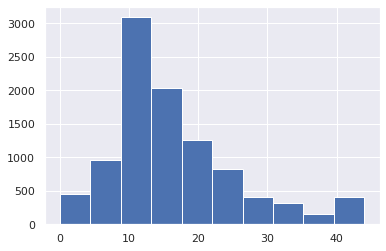

In [33]:
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

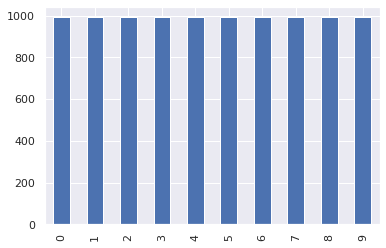

In [34]:
train_df['fold'] = -1

N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().sort_index().plot.bar()

In [35]:
train_df[train_df['fold']==0]['bins'].value_counts()

10    79
15    72
13    63
11    62
12    62
14    53
9     44
16    41
20    37
17    37
18    36
8     32
44    30
7     28
19    28
21    23
5     21
25    20
22    19
0     17
24    16
23    16
6     16
26    13
28    12
29    10
30     9
27     9
4      8
31     8
3      8
1      7
32     6
33     6
34     6
35     6
2      6
36     4
40     4
39     4
37     4
41     3
38     3
43     2
42     2
Name: bins, dtype: int64

# Create a Model

In [36]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [37]:
USE_META = False

# augmentaion to apply when loading image data
augmentation = [Flip(), Brightness(), Contrast(), Hue(), Saturation()]

meta_target = train_df.drop(['norm_score','Pawpularity','path', 'fold', 'bins'],1).keys().tolist()
print("meta len:",len(meta_target))

def get_data(fold: int) -> fastai.data.core.DataLoaders:
    """
    get data for only given fold number and load the data into fastai dataloader
    and return it
    """
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, 
                                    valid_pct=0.2, #80-20 train-validation random split
                                    valid_col='is_valid', 
                                    seed=SEED, 
                                    fn_col='path', #filename/path is in the second column of the DataFrame
                                    label_col='norm_score', #label is in the first column of the DataFrame
                                    y_block=RegressionBlock, #The type of target
                                    bs=BATCH_SIZE, 
                                    num_workers=NUM_WORKERS,
                                    item_tfms=Resize(IMAGE_SIZE), 
                                    batch_tfms=setup_aug_tfms(augmentation))  
    return dls

meta len: 15


In [38]:
# USE_META = False

# # augmentaion to apply when loading image data
# augmentation = [Flip(), Brightness(), Contrast(), Hue(), Saturation()]

# meta_target = train_df.drop(['norm_score','Pawpularity','path', 'fold', 'bins'],1).keys().tolist()
# print("meta len:",len(meta_target))

# def get_data(fold: int) -> fastai.data.core.DataLoaders:
#     """
#     get data for only given fold number and load the data into fastai dataloader
#     and return it
#     """
#     train_df_f = train_df.copy()
#     # add is_valid for validation fold
#     train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
#     paw_block = DataBlock(blocks = (ImageBlock, RegressionBlock) ,  # input/ output
#                         get_x = [ColReader('path')], 
#                         get_y = ColReader('norm_score') , 
#                         item_tfms = Resize(IMAGE_SIZE), 
#                         batch_tfms = setup_aug_tfms(augmentation))

#     dls = paw_block.dataloaders(train_df_f, 
#                                 batch_size=BATCH_SIZE, 
#                                 y_block=RegressionBlock, 
#                                 num_workers=NUM_WORKERS)
    
#     return dls

In [39]:
# in colab, change the path to avoid error in the below cell
if USE_COLAB:
  os. chdir('../')

In [40]:
#Valid Kfolder size
the_data = get_data(0)
print('finished')
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

finished


In [41]:
the_data = get_data(0)
type(the_data)

fastai.data.core.DataLoaders

In [42]:
# class PawpularModel(nn.Module):
#     def __init__(self, model_name='swin_large_patch4_window7_224', 
#                  num_classes=[17,1], n_meta_dim=[256, 128], pretrained=True):
#         super().__init__()
#         out_dim=num_classes[1]
#         n_meta_features=num_classes[0]
#         self.n_meta_features = n_meta_features
#         self.enet = create_model(model_name, pretrained=True, in_chans=3)
#         self.dropouts = nn.ModuleList([nn.Dropout(0.5) for _ in range(5)])
#         in_ch = self.enet.head.in_features

#         if n_meta_features > 0:
#             self.meta = nn.Sequential(
#                 nn.Linear(n_meta_features, n_meta_dim[0]),
#                 nn.BatchNorm1d(n_meta_dim[0]),
#                 nn.SiLU(),
#                 nn.Dropout(p=0.3),
#                 nn.Linear(n_meta_dim[0], n_meta_dim[1]),
#                 nn.BatchNorm1d(n_meta_dim[1]),
#                 nn.SiLU(),
#             )

#             in_ch += n_meta_dim[1]
#         self.myfc = nn.Linear(in_ch, out_dim)
#         self.enet.head = nn.Identity()


#     def extract(self, x):
#         x = self.enet(x)
#         return x


#     def forward(self, image, features):
#         x = self.extract(image).squeeze(-1).squeeze(-1)
#         if self.n_meta_features > 0:
#             x_meta = self.meta(features)
#             x = torch.cat((x, x_meta), dim=1)
#         for i, dropout in enumerate(self.dropouts):
#             if i == 0:
#                 out = self.myfc(dropout(x))
#             else:
#                 out += self.myfc(dropout(x))
#         out /= len(self.dropouts)
#         return out

In [43]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model(MODEL_NAME, 
                         pretrained=True, 
                         num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), 
                    metrics=petfinder_rmse).to_fp16()
    
    return learn

In [44]:
# config to use trained model in google colab or train a model in kaggle notebook
USE_PRETRAINED = False

#if not USE_PRETRAINED:
    # plot how learning rate affects loss. Get the bottom of the slope and steepest point
    # lr_min,lr_steep = get_learner(fold_num=0).lr_find(end_lr=1e-2)
    # res = get_learner(fold_num=0).lr_find(end_lr=1e-2)
    

In [ ]:
%%time
# params
FINETUNE = True
EPOCHS = 3
FINETUNE_EPOCHS = 3

# empty list to store predicted score
all_preds = []

for i in range(N_FOLDS):
    print(f'Fold {i} results')
    
    # if USE_PRETRAINED is True, use the model trained in google colab
    if USE_PRETRAINED:
        # Change the model path accordingly depending on colab or kaggle
        if not USE_COLAB:
            # model path for kaggle environment (kaggle dataset)
            model_path = Path(f'../input/paw-model-20211229-v2/model_fold_{i}.pkl')
        else:
            # model path for google colab (stored in google drive)
            model_path = Path(f'/content/drive/MyDrive/kaggle/pawpularity/model/model_fold_{i}.pkl')

        learn = load_learner(model_path, cpu=False)
        learn.model = learn.model.cuda()
        learn.dls.to('cuda')

    else:
        # train in google colab environment (takes time)
        model_path = os.path.join(dataset_path, f'model/model_fold_{i}.pkl')
        learn = get_learner(fold_num=i)

        # train the last layer group
        learn.fit_one_cycle(EPOCHS, 
                            2e-5, 
                            cbs=[SaveModelCallback(), 
                                 EarlyStoppingCallback(monitor='petfinder_rmse', 
                                                       comp=np.less, 
                                                       patience=2)]) 
        
        if i == 0:
            learn.lr_find()

        # finetune the model based on Jason Yosinski's adoptive learning rate idea
        # implement low lr for initinal layer & high lr for last layer
        if FINETUNE:
            learn.unfreeze()
            print(f'Fold {i} fine-tune')   
            learn.fit_one_cycle(FINETUNE_EPOCHS, 
                                lr_max=slice(1e-6, 1e-4), 
                                cbs=[SaveModelCallback(), 
                                     EarlyStoppingCallback(monitor='petfinder_rmse', 
                                                           comp=np.less, 
                                                           patience=2)])
        
        learn.recorder.plot_loss()
        learn = learn.to_fp32()
        learn.export(model_path)
    
    dls = ImageDataLoaders.from_df(train_df, 
                                   valid_pct=0.2, #80-20 train-validation random split
                                   seed=SEED, 
                                   fn_col='path', #filename/path is in the second column of the DataFrame
                                   label_col='norm_score', #label is in the first column of the DataFrame
                                   y_block=RegressionBlock, #The type of target
                                   bs=BATCH_SIZE, 
                                   num_workers=NUM_WORKERS,
                                   item_tfms=Resize(IMAGE_SIZE), 
                                   batch_tfms=setup_aug_tfms(augmentation))  
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    del learn
    torch.cuda.empty_cache()
    gc.collect()
    print("*"*79)

Fold 0 results


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,petfinder_rmse,time


In [ ]:
learn = get_learner(fold_num=0)

# Save the model to GCS ($$$)
1. Copy the model in google drive to google cloud storage using the below code
2. Create dataset in kaggle. Load the models from GCS (much faster than uploading manually)
3. In Kaggle notebook, add the dataset created in step 2
4. Set USE_PRETRAINED variable to True and run the notebook. <- This will predict score based on the model trained in google colab

In [ ]:
# from google.colab import auth
# from googleapiclient.discovery import build
# from googleapiclient.http import MediaFileUpload
# import yaml

# auth.authenticate_user()
# gcs_service = build('storage', 'v1')

# # Read gcs credential stored in yaml file
# yaml_path = "/content/drive/MyDrive/kaggle/pawpularity/gcs_secret.yaml"
# yaml_dict = yaml.load(open(yaml_path).read())
# bucket_name = yaml_dict['bucket_name']
# project_id = yaml_dict['project_id']

In [ ]:
# !zip "/content/drive/MyDrive/kaggle/pawpularity/model.zip" "/content/drive/MyDrive/kaggle/pawpularity/model"

In [ ]:
# %%time

# for i in range(5):
#     model_path = os.path.join(dataset_path, f'model/model_fold_{i}.pkl')

#     print(f'saving model_fold_{i}.pkl in GCS ...')
#     media = MediaFileUpload(model_path, 
#                             mimetype='application/octet-stream',
#                             resumable=True)

#     request = gcs_service.objects().insert(bucket=bucket_name, 
#                                             name=f'model_fold_{i}.pkl',
#                                             media_body=media)

#     response = None
#     while response is None:
#         # _ is a placeholder for a progress object that we ignore.
#         # (Our file is small, so we skip reporting progress.)
#         _, response = request.next_chunk()

# print('Upload complete')
# print('https://console.cloud.google.com/storage/browser?project={}'.format(project_id))

# Create output

In [ ]:
np.mean(np.stack(all_preds*100))

In [ ]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [ ]:
pd.read_csv('submission.csv').head()